### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-43ffc6c0-2035-c9cb-0251-168dcd57663c)


In [ ]:
%%capture
!pip install diffusers
!pip install accelerate
!pip install daam
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

In [ ]:
!pip uninstall -y daami2i
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git

Found existing installation: daami2i 0.0.1
Uninstalling daami2i-0.0.1:
  Successfully uninstalled daami2i-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RishiDarkDevil/daam-i2i.git to /tmp/pip-req-build-cxki8plx
  Running command git clone --filter=blob:none --quiet https://github.com/RishiDarkDevil/daam-i2i.git /tmp/pip-req-build-cxki8plx
  Resolved https://github.com/RishiDarkDevil/daam-i2i.git to commit a8fcbb7577e9a98e82329eeba2998b35a2ebbea5
  Preparing metadata (setup.py) ... done
  Created wheel for daami2i: filename=daami2i-0.0.1-py3-none-any.whl size=23927 sha256=ca85bec479912ef32d6c2fc8d98ad7e2774d564fc4ecc5d25c6976d004367671
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3d4u4dq/wheels/5f/a6/fa/54144697d34b2f01ecfe3ed8cc7361f099d5dfe0e6fc3c75dc
Successfully built daami2i


### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [ ]:
# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionPipeline

# Heatmap generation
import daam
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [ ]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [ ]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [ ]:
prompt = ['A boy and girl playing football on a grass field.']

In [ ]:
processed_prompt = titan.PromptHandler().clean_prompt(prompt)

Loading Models...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Done
Tokenizing...Done
POS Tagging and Lemmatizing...Done
Processing...Done


In [ ]:
prompt, cleaned_prompt, objects = processed_prompt[0]
processed_prompt

[('a boy and girl playing football on a grass field .',
  ['boy', 'girl', 'football', 'grass', 'field'],
  ['boy', 'girl', 'football', 'grass', 'field'])]

In [ ]:
with daam.trace(model) as daam_trc, daami2i.trace(model) as daami2i_trc:
  output_image = model(prompt).images[0]
  image_global_heat_map = daami2i_trc.compute_global_heat_map()
  word_global_heat_map = daam_trc.compute_global_heat_map()

  0%|          | 0/51 [00:00<?, ?it/s]

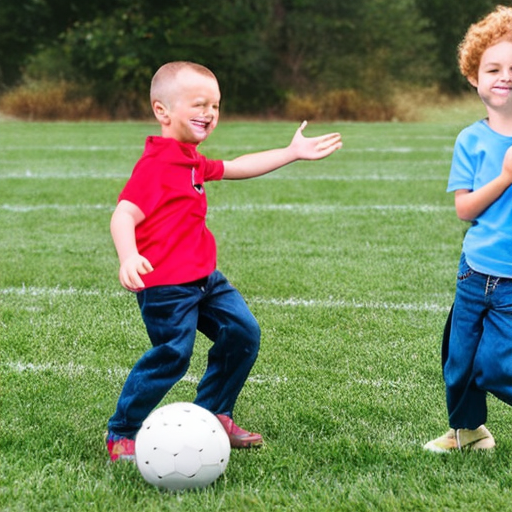

In [ ]:
output_image

### Visualize Heatmaps

In [ ]:
# annotations = list()
object_annotator = titan.ObjectAnnotator()

In [ ]:
def plot_all(word):
  fig, ax = plt.subplots(2, 2, figsize=(12,12))
  fig.suptitle(f'Attention Heatmaps for {word}', fontsize=16)
  word_heatmap = word_global_heat_map.compute_word_heat_map(word)
  word_annotation = [ann['segmentation'] for ann in object_annotator.wordheatmap_to_annotations(word_heatmap.expand_as(output_image).numpy())]
  # Text2Image DAAM Heatmap
  ax[0,0].imshow(word_heatmap.expand_as(output_image).numpy())
  ax[0,0].axis('off')
  ax[0,0].set_title('DAAM')
  # Contour Image2Image Heatmap (DAAMI2I NW)
  ax[0,1].imshow(image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1]).expand_as(output_image).numpy())
  ax[0,1].axis('off')
  ax[0,1].set_title('DAAMI2I NW')
  # Guided Image2Image Heatmap (DAAMI2I W)
  ax[1,0].imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap.heatmap).expand_as(output_image).numpy())
  ax[1,0].axis('off')
  ax[1,0].set_title('DAAMI2I W')
  # Contour + Guidance within Contour Image2Image Heatmap (DAAMI2I NW+W)
  ax[1,1].imshow(image_global_heat_map.compute_segmentation_heat_map(word_annotation, output_image.size[0], output_image.size[1], word_heatmap.heatmap).expand_as(output_image).numpy())
  ax[1,1].axis('off')
  ax[1,1].set_title('DAAMI2I NW+W')

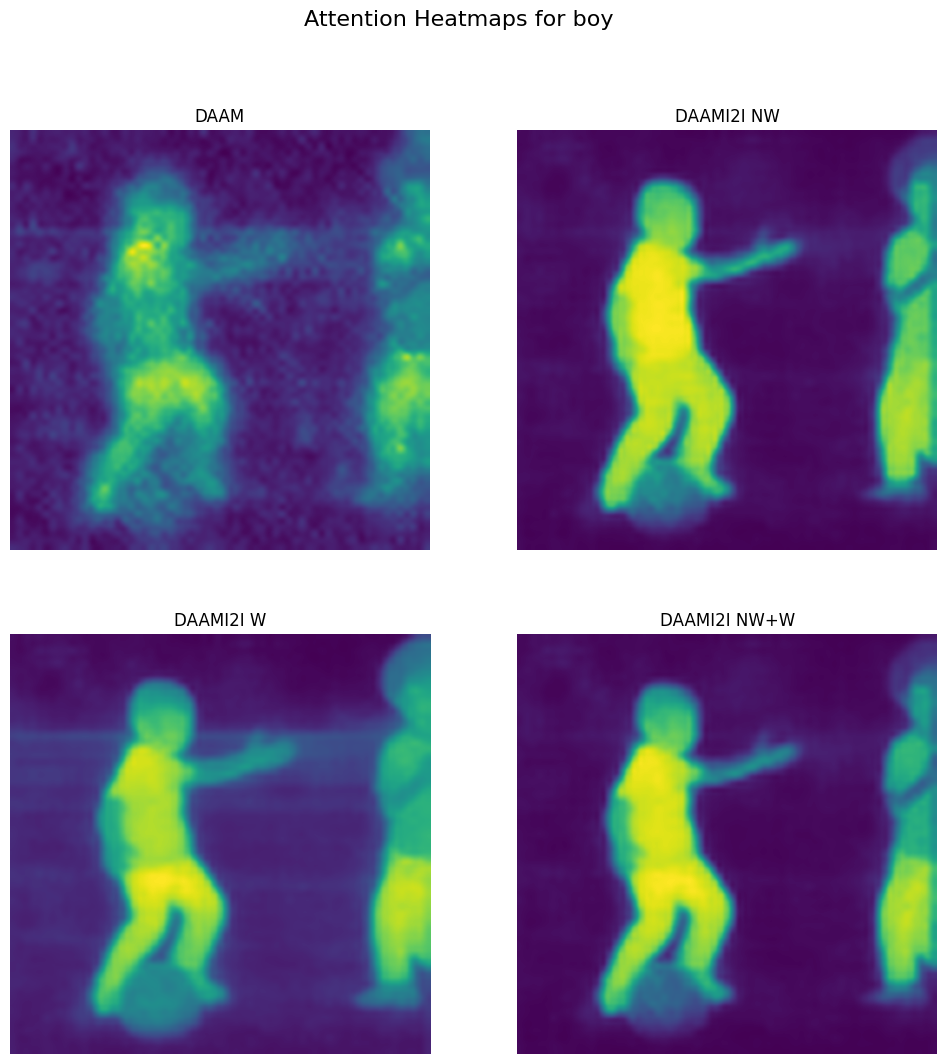

In [ ]:
plot_all(cleaned_prompt[0])

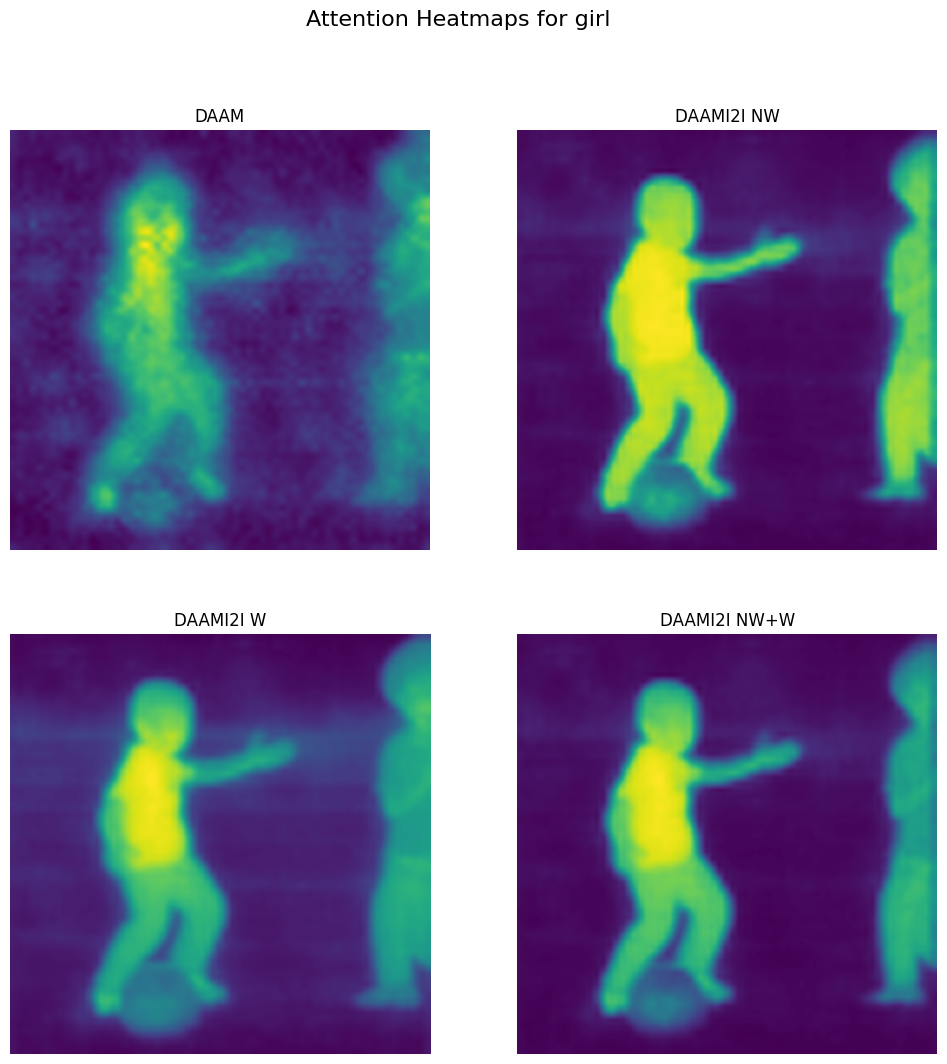

In [ ]:
plot_all(cleaned_prompt[1])

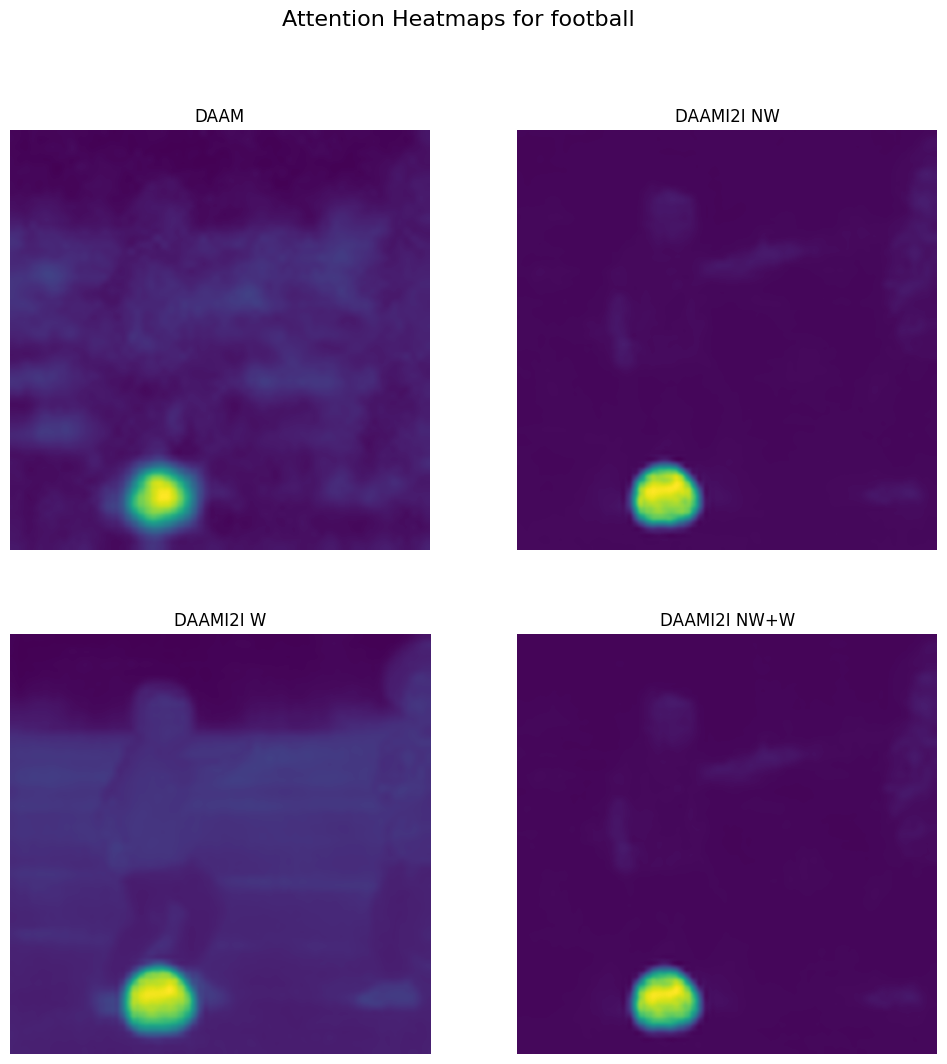

In [ ]:
plot_all(cleaned_prompt[2])

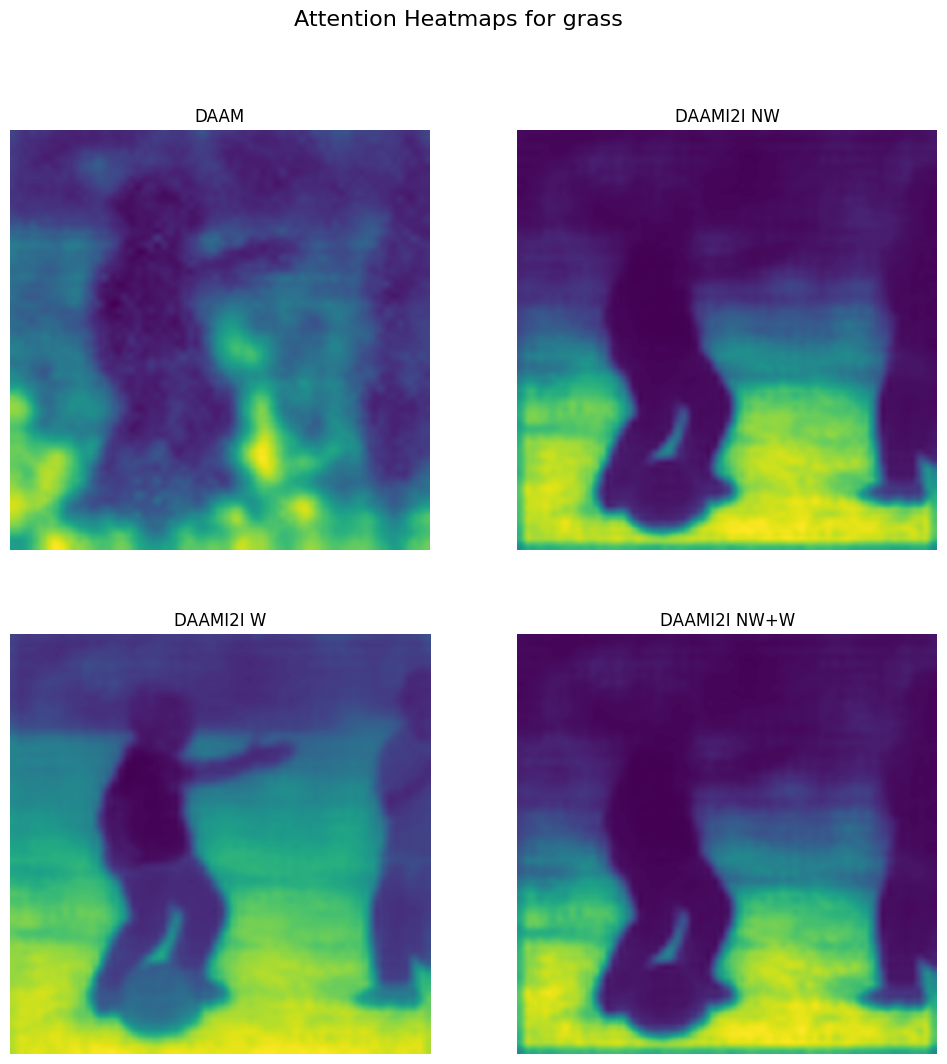

In [ ]:
plot_all(cleaned_prompt[3])

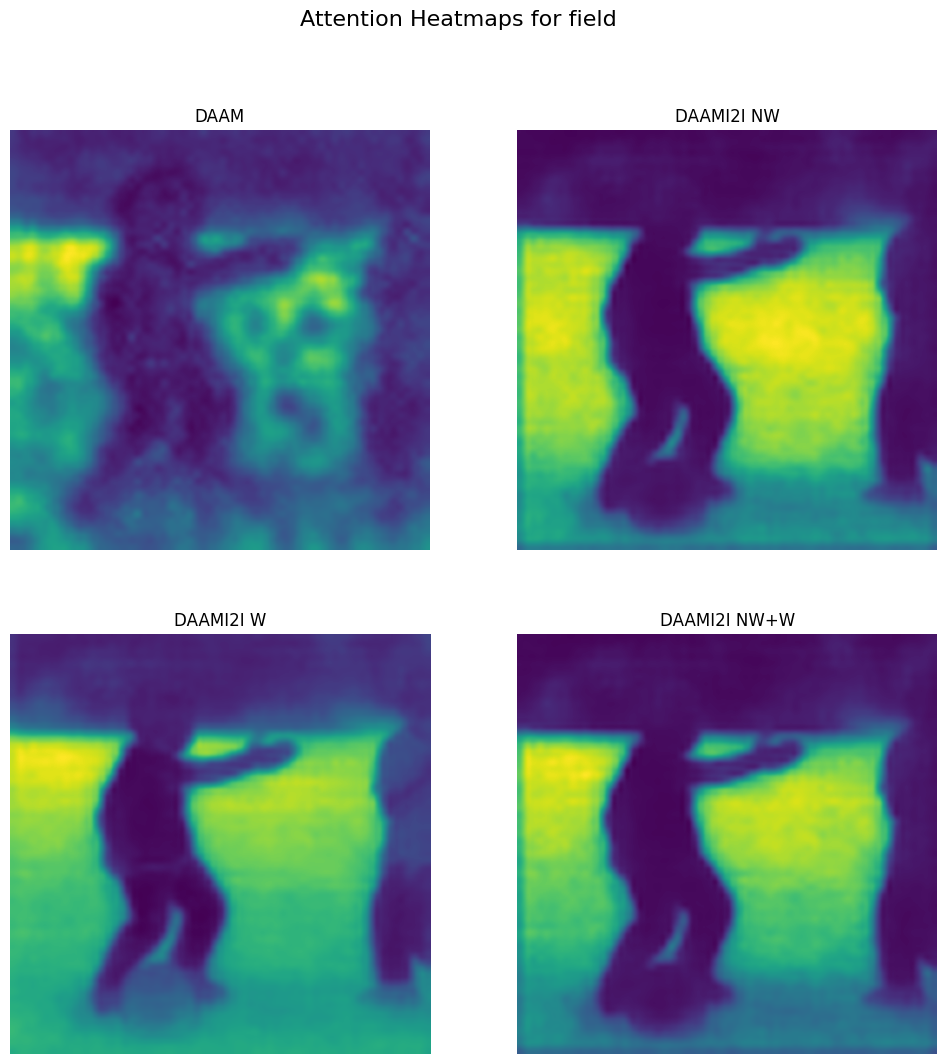

In [ ]:
plot_all(cleaned_prompt[4])

### Object Detections

In [58]:
def annotate_word(word):
  word_heatmap = word_global_heat_map.compute_word_heat_map(word)
  word_annotation = object_annotator.wordheatmap_to_annotations(word_heatmap.expand_as(output_image).numpy())
  object_annotator.show_annotations(np.asarray(output_image), word_annotation, figsize=(10,10))
  plt.title(f'Object Detection for {word}')

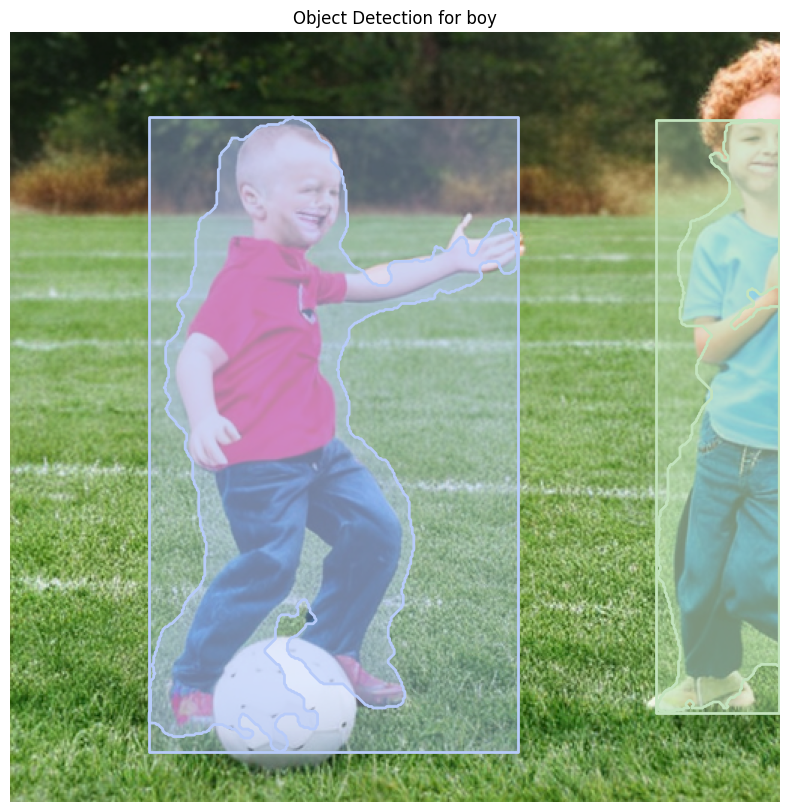

In [59]:
annotate_word(cleaned_prompt[0])

In [ ]:
annotate_word(cleaned_prompt[0])